# Twitch Chat Scraping


In [2]:
### Imports

from Twitch_key import * ### I made this .py file to house my Twitch_API_KEY
import socket

import logging
import time
from emoji import demojize


import pandas as pd
from datetime import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#######  Setting up the Twitch IRC Socket - Part 1: General Info ####### 

server = 'irc.chat.twitch.tv' #twitch provided
port = 6667 #twitch provided
nick = 'b_e_green' #your OWN twitch account
token = Twitch_key() #however you'd like to generate your oauth token
channel = input("What Channel are we scraping?: ")# '#QTCinderella' #the channel you want to scrape from; change to whomever! make sure the handle is lowercase

What Channel are we scraping?: #qtcinderella


In [4]:
#######  Did you pick the right channel? ####### 

channel

'#qtcinderella'

In [5]:
#######  Only need to run once ####### 

log_name = 'chat'+time.strftime("%Y_%m_%d")+'.log'
log_name

'chat2022_03_17.log'

In [6]:
### Create a log file that saves your pull!
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s — %(message)s',
                    datefmt='%Y-%m-%d_%H:%M:%S',
                    handlers=[logging.FileHandler(log_name, encoding='utf-8')])

In [9]:
####### Pulling comments via the Connection ####### 

### Connect to Socket
sock = socket.socket()
sock.connect((server, port))

sock.send(f"PASS {token}\n".encode('utf-8'))
sock.send(f"NICK {nick}\n".encode('utf-8'))
sock.send(f"JOIN {channel}\n".encode('utf-8'))


### Loop for pull - I included a timer to run for a certain amount of seconds
start_time = time.time()
seconds = input("Enter number of seconds you want this to run: ")
seconds = int(seconds)
while True:
    current_time = time.time()
    elapsed_time = current_time - start_time

    resp = sock.recv(2048).decode('utf-8')

    if resp.startswith('PING'):
        sock.send("PONG\n".encode('utf-8'))
        print('PING-PONG!')
    
    elif len(resp) > 0: # if you'd like to remove emojis from the text; Twitch uses a lot of them!
        logging.info(demojize(resp))
        
    if elapsed_time > seconds:
        print("Finished iterating in: " + str(int(elapsed_time))  + " seconds")
        break
        sock.close() #closes the socket after your time runs out

Enter number of seconds you want this to run: 600
Finished iterating in: 600 seconds


In [10]:
####### Generate a dataframe from the comments you pulled ####### 

### function to create dataframe from chat snippet
def get_chat_dataframe(file):
    data = []

    with open(file, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n\n')
        
        for line in lines:
#             print(line)
            try:
                cmnt_time = line.split('—')[0].strip()
                cmnt_time = datetime.strptime(cmnt_time, '%Y-%m-%d_%H:%M:%S')

                msg = line.split('—')[1:]
                msg = '—'.join(msg).strip()

                username, channel, message = re.search(
                    ':(.*)\!.*@.*\.tmi\.twitch\.tv PRIVMSG #(.*) :(.*)', msg
                ).groups()

                d = {
                    'dt': cmnt_time,
                    'channel': channel,
                    'username': username,
                    'message': message
                }

                data.append(d)
            
            except Exception:
                pass
            
    return pd.DataFrame(data)
        

In [11]:
####### Run DF function #######

df = get_chat_dataframe(log_name)

In [12]:
####### Take a look at your dataframe! #######

#df.set_index('dt', inplace=True) #use if you want the index to be the time variable

### The shape of your DF
print(df.shape)


### Head & Tail of DF
display(df.head(), df.tail())


### What are the column data types for your DF?

print(df.dtypes)

(910, 4)


,dt,channel,username,message
0,2022-03-17 23:04:01,qtcinderella,hellrauser,sagde
1,2022-03-17 23:04:03,qtcinderella,groovy1,thats a big room
2,2022-03-17 23:04:06,qtcinderella :me,mythrilfenix,(
3,2022-03-17 23:04:07,qtcinderella,plantcats,What year?
4,2022-03-17 23:04:07,qtcinderella,natabeee,OINKING


,dt,channel,username,message
905,2022-03-17 23:13:23,qtcinderella,mlengka,oh sheet
906,2022-03-17 23:13:23,qtcinderella,eviteri97,#ask what is your favorite Beatles song and al...
907,2022-03-17 23:13:26,qtcinderella,thaleslol,#ask were ders and swift your pets or lud
908,2022-03-17 23:13:27,qtcinderella,wonderful_wilderness,kekw
909,2022-03-17 23:13:27,qtcinderella,jumbawill,ending of hbp was awesome


dt          datetime64[ns]
channel             object
username            object
message             object
dtype: object


wonderful_wilderness    22
socks_____              19
sapphic_sierra          15
catghouls               15
cj_dr20                 14
natabeee                14
selachii_ii             12
amrut_                  12
dragonslayer5472        12
mena369                 10
Name: username, dtype: int64 

##############


qtcinderella                                             903
qtcinderella :lmao                                         1
qtcinderella :maya is so smol easy to sneak in places      1
qtcinderella :i love the office                            1
qtcinderella :LULW                                         1
qtcinderella :me                                           1
qtcinderella :i like the office                            1
qtcinderella :KEKW                                         1
Name: channel, dtype: int64 

##############




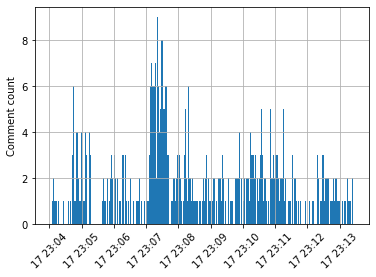

In [14]:
####### Explore #######

print(df.username.value_counts()[:10], '\n\n##############\n\n')

print(df.channel.value_counts()[:10], '\n\n##############\n\n')

ax = df.dt.hist(xrot=45, bins = (df.dt.max() - df.dt.min()).seconds)

ax.set_ylabel('Comment count')
ax.grid('off')
plt.show()